# S4E1 - Bank Churn Predictions - Decision Tree and Random Forest

# Config

In [1]:
class Config():
    seed = 12
    folds = 5

config = Config()

# Imports

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

# Load Files

In [3]:
root_dir = '/kaggle/input/playground-series-s4e1'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

# Top Level EDA

In [4]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (165034, 14)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


Test Data Shape: (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


Sample Submission Shape: (110023, 2)


,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [5]:
display(train.describe().style.background_gradient(cmap='Blues'))
display(test.describe().style.background_gradient(cmap='Blues'))

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.500000,15692005.019026,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.356500,71397.816791,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.250000,15633141.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.500000,15690169.000000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.750000,15756824.000000,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,220045.000000,15692096.605101,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,31761.048671,71684.990992,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,165034.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,192539.500000,15632859.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,220045.000000,15690175.000000,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,247550.500000,15756926.000000,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,275056.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


In [6]:
def num_of_unique_elements(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
  summary['missing#'] = df.isna().sum() 
  summary['missing%'] = (df.isna().sum())/len(df) 
  summary['uniques'] = df.nunique().values 
  summary['count'] = df.count().values 
  return summary

num_of_unique_elements(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,165034,165034
CustomerId,int64,0,0.000000,23221,165034
Surname,object,0,0.000000,2797,165034
CreditScore,int64,0,0.000000,457,165034
Geography,object,0,0.000000,3,165034
Gender,object,0,0.000000,2,165034
Age,float64,0,0.000000,71,165034
Tenure,int64,0,0.000000,11,165034
Balance,float64,0,0.000000,30075,165034
NumOfProducts,int64,0,0.000000,4,165034


* 165K rows in train, 110K rows in test, 13 features + target
* No missing data
* Some categorical/binary columns
* Some columns have non-optimum data types
* Age should be int

In [7]:
# maybe later look at surname
#train.Surname.value_counts()
train.Geography.value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

## Convert Datatypes
* to something more reasonable
* Gender, HasCrCard, IsActiveMember, Exited to boolean


In [8]:
# convert colums to boolean 
bool_cols = [col for col in train.columns if train[col].nunique()==2]
train[bool_cols] = train[bool_cols].astype('bool')

y = train.Exited
bool_cols.remove('Exited')
test[bool_cols] = test[bool_cols].astype('bool')

In [9]:
# one hot encode non-ordinal columns (geography)
train = pd.concat([train, pd.get_dummies(train['Geography'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['Geography'])], axis=1)
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,0,15674932,Okwudilichukwu,668,France,True,33.0,3,0.00,2,True,False,181449.97,False,True,False,False
1,1,15749177,Okwudiliolisa,627,France,True,33.0,1,0.00,2,True,True,49503.50,False,True,False,False
2,2,15694510,Hsueh,678,France,True,40.0,10,0.00,2,True,False,184866.69,False,True,False,False
3,3,15741417,Kao,581,France,True,34.0,2,148882.54,1,True,True,84560.88,False,True,False,False
4,4,15766172,Chiemenam,716,Spain,True,33.0,5,0.00,2,True,True,15068.83,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,True,33.0,2,0.00,1,True,True,131834.75,False,False,False,True
165030,165030,15665521,Okechukwu,792,France,True,35.0,3,0.00,1,False,False,131834.45,False,True,False,False
165031,165031,15664752,Hsia,565,France,True,31.0,5,0.00,1,True,True,127429.56,False,True,False,False
165032,165032,15689614,Hsiung,554,Spain,True,30.0,7,161533.00,1,False,True,71173.03,False,False,False,True


In [10]:
train.drop('Geography', axis=1, inplace=True)
test.drop('Geography', axis=1, inplace=True)

In [11]:
not_used_cols = ['id','CustomerId','Surname']

train.drop(not_used_cols, axis=1, inplace=True)
test.drop(not_used_cols, axis=1, inplace=True)

# EDA of float cols

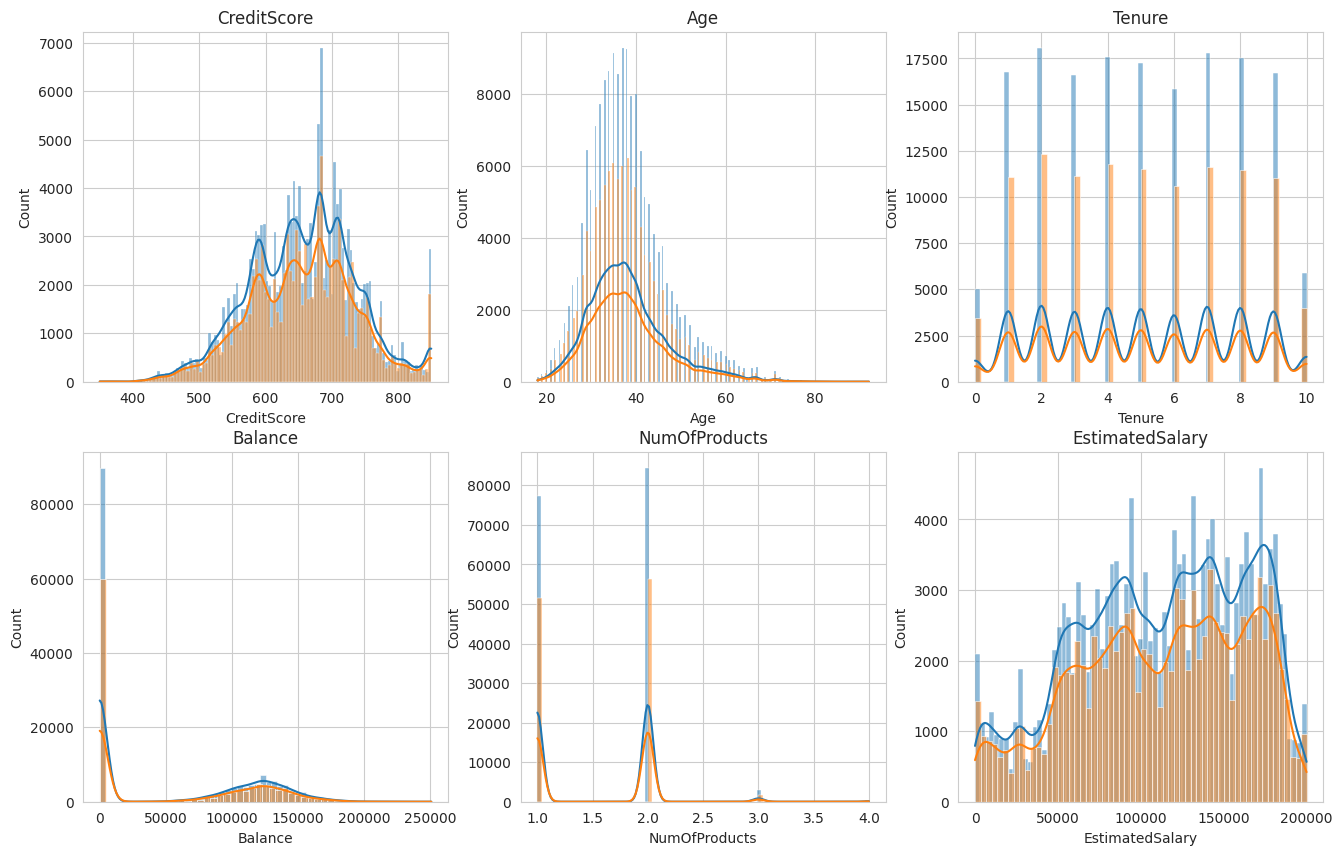

In [12]:
features = [col for col in train.columns if train[col].dtype=='float' or train[col].dtype=='int']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(16,5*rows)) 
for i,col in enumerate(features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)

Text(0.5, 1.0, 'Target Value Counts')

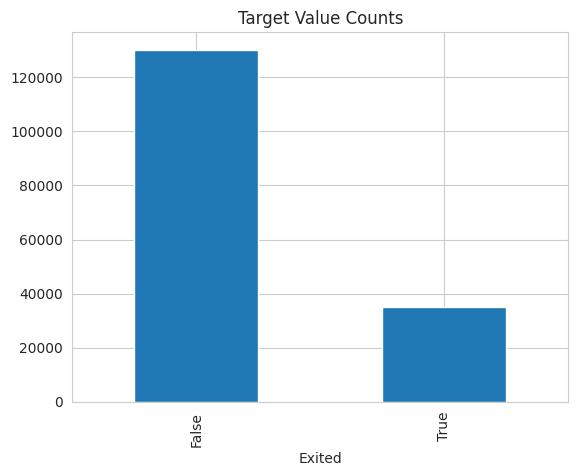

In [13]:
y.value_counts().plot(kind='bar')
plt.title('Target Value Counts')

* Some target class imbalance
    * Try oversampling

# Correlations

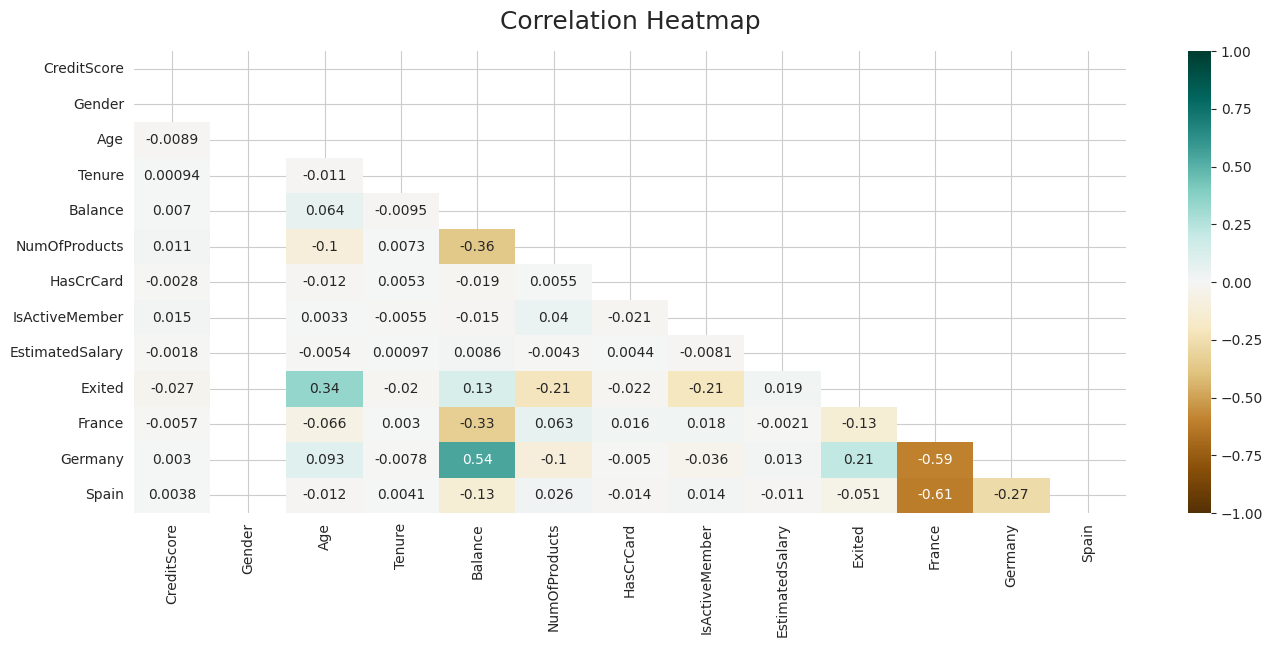

In [14]:
plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(train.corr(),dtype=bool)) 
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

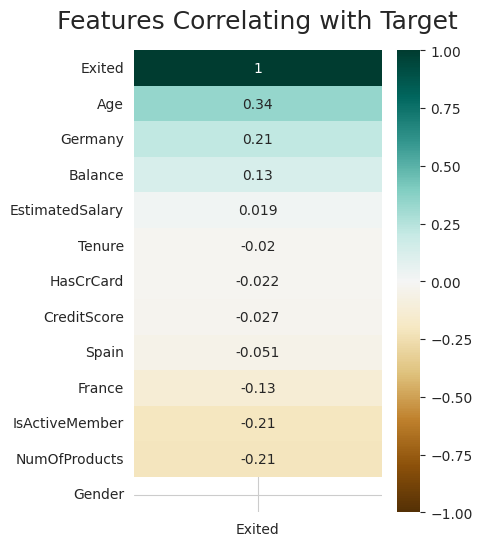

In [15]:
plt.figure(figsize=(4, 6)) # set size by num of features 
heatmap = sns.heatmap(train.corr()[['Exited']].sort_values(by='Exited', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);

## Select Features

In [16]:
features = [col for col in test.columns]
features

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'France',
 'Germany',
 'Spain']

# Models

In [17]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

## Train/test Split

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(train[features], y, train_size=0.8, test_size=0.2,
                                                      random_state=config.seed)
X_test = test[features]

### Cross Validation

In [19]:
def run_cv_and_predict(train, test, features, model, seed, verbose=True):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],config.folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=config.folds,random_state = config.seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = roc_auc_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
          print(f'Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])[:,1]
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = roc_auc_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'ROC AUC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()

preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,config.seed,verbose=True)

# default: 0.71144,                  lb = .70793
# with cross validation: .71380,     lb = .70791

Score, fold 1: 0.710548969611383
Score, fold 2: 0.7144851271315678
Score, fold 3: 0.7136109362503757
Score, fold 4: 0.7151712990830346
Score, fold 5: 0.7151868087343135
ROC AUC score: 0.71380, Stdev: 0.00172, OOF score: 0.71380


## Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(max_depth=7)

preds_dt,scores_dt,oof_score_dt,oof_dt = run_cv_and_predict(train,test,features,model_dt,config.seed,verbose=True)

# default .69954
# max_depth = 3: .84321
# max_depth = 4: .86051
# max_depth = 5: .87173
# max_depth = 6: .88061
# max_depth = 7: .88137, lb = 
# max_depth = 8: .88028
# max_depth = 9: .87648

Score, fold 1: 0.8774231499723195
Score, fold 2: 0.8823476420475516
Score, fold 3: 0.8826781222347189
Score, fold 4: 0.8803988030171266
Score, fold 5: 0.8840218263416725
ROC AUC score: 0.88137, Stdev: 0.00229, OOF score: 0.88125


In [22]:
model_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [23]:
model_dt.fit(X_train, y_train)
y_pred = model_dt.predict(X_valid)
confusion_matrix(y_valid, y_pred)

array([[24533,  1479],
       [ 3124,  3871]])

In [24]:
# from sklearn import tree

# tree.plot_tree(model_dt)
# plt.show()

# Final Model Selection and Submission

In [25]:
final_preds = preds_dt.mean(axis=1)

In [26]:
ss.Exited = final_preds
ss.to_csv('submission.csv',index=False)
ss.head()

,id,Exited
0,165034,0.010013
1,165035,0.823805
2,165036,0.025744
3,165037,0.389905
4,165038,0.382685


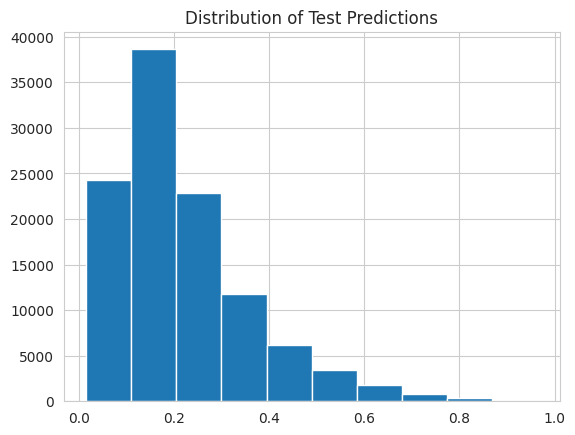

In [27]:
plt.hist(preds_lr.mean(axis=1))
plt.title('Distribution of Test Predictions')
plt.show()